# **Breast Cancer Survival Prediction**

Breast cancer is a significant global health concern, with early detection and survival prediction being paramount for effective treatment planning. This notebook presents a machine learning-based approach to predict the survival outcome of breast cancer patients. By leveraging a dataset containing relevant features such as tumor size, lymph node status, and histological characteristics, we aim to develop a robust predictive model. Through this analysis, we aspire to provide valuable insights for medical professionals, aiding in personalized patient care and treatment strategies. The combination of data-driven techniques and clinical knowledge has the potential to enhance our ability to make informed decisions regarding the prognosis of breast cancer patients, ultimately contributing to improved healthcare outcomes.

### **About Dataset**

**Dataset Source:** [https://www.kaggle.com/datasets/reihanenamdari/breast-cancer](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer)

### **Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Preparing Dataframe**

In [6]:
filepath = "/content/drive/MyDrive/Semester 5/Healthcare Analytics/Breast_Cancer.csv"
df = pd.read_csv(filepath)

### **General Inspection**
Let's start by displaying the top 5 rows.

In [8]:
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [9]:
df.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [10]:
df.shape

(4024, 16)

There are 16 columns and 4024 rows in the dataset.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

As we can see there is no missing value in the dataset.

In [12]:
df.isna().any().any()

False

In [13]:
df['Status'].value_counts()

Alive    3408
Dead      616
Name: Status, dtype: int64

### **Visualizing Data**

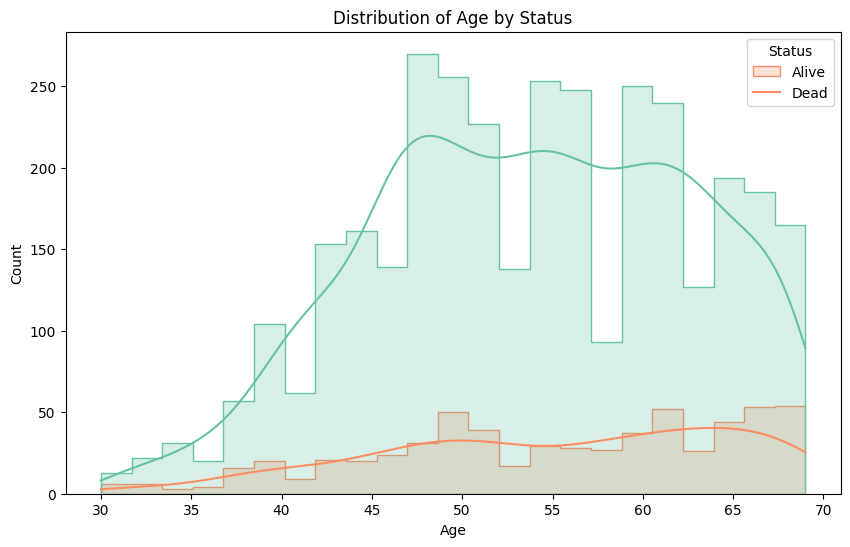

In [14]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='Age', hue='Status', kde=True, palette='Set2', element='step', common_norm=False)
plt.title('Distribution of Age by Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Alive', 'Dead'])

plt.show()

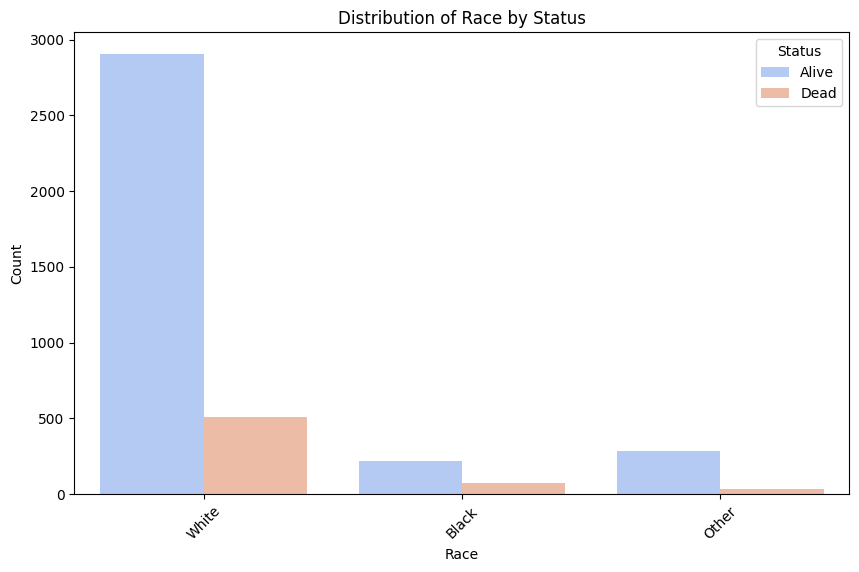

In [15]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x='Race', hue='Status', palette='coolwarm')
plt.title('Distribution of Race by Status')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Alive', 'Dead'])

plt.xticks(rotation=45)

plt.show()

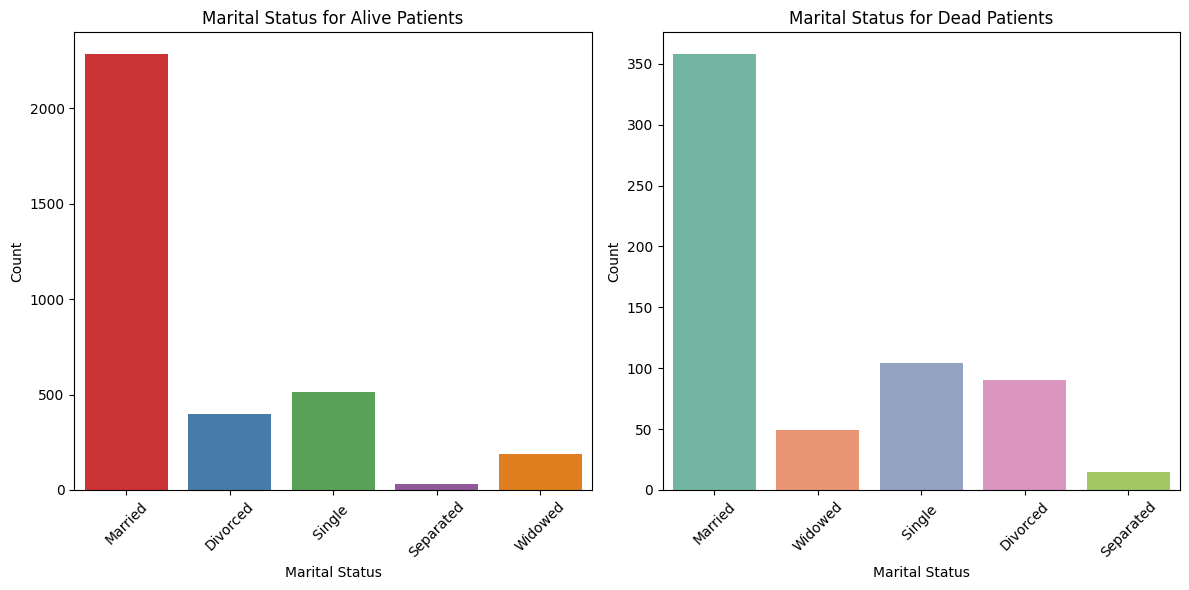

In [16]:
alive_df = df[df['Status'] == 'Alive']
dead_df = df[df['Status'] == 'Dead']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.countplot(data=alive_df, x='Marital Status', palette='Set1')
plt.title('Marital Status for Alive Patients')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)

sns.countplot(data=dead_df, x='Marital Status', palette='Set2')
plt.title('Marital Status for Dead Patients')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

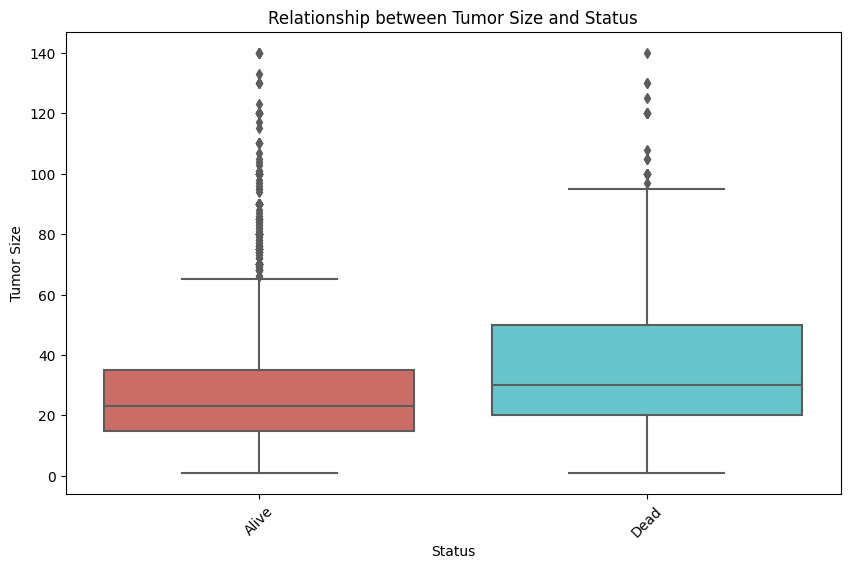

In [17]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Status', y='Tumor Size', palette='hls')
plt.title('Relationship between Tumor Size and Status')
plt.xlabel('Status')
plt.ylabel('Tumor Size')
plt.xticks(rotation=45)

plt.show()

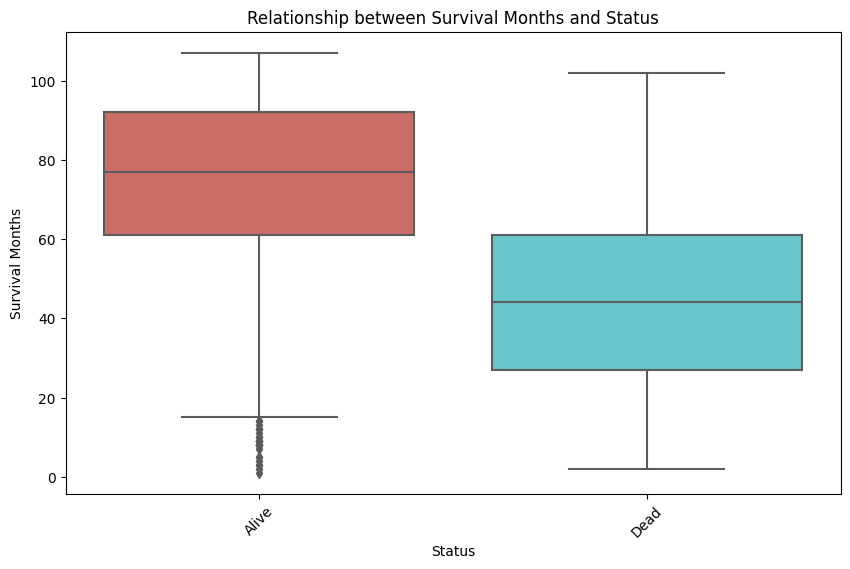

In [18]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Status', y='Survival Months', palette='hls')
plt.title('Relationship between Survival Months and Status')
plt.xlabel('Status')
plt.ylabel('Survival Months')
plt.xticks(rotation=45)

plt.show()

### **Pre-processing steps**

In [19]:
df.rename(columns={"T Stage ": "T Stage"}, inplace=True)
df["Grade"].replace({" anaplastic; Grade IV": "4"}, inplace=True)
df["Grade"] = df["Grade"].astype(int)
df["T Stage"].replace({"T1":1, "T2": 2, "T3":3, "T4": 4}, inplace=True)
df["N Stage"].replace({"N1":1, "N2": 2, "N3":3}, inplace=True)
df["6th Stage"].replace({"IIA":1, "IIB": 2, "IIIA":3, "IIIB": 4,"IIIC":5}, inplace=True)
df["differentiate"].replace({"Moderately differentiated": 2,
                            "Poorly differentiated": 1,
                            "Well differentiated": 3,
                            "Undifferentiated": 0}, inplace=True)
df["A Stage"].replace({"Regional":1, "Distant": 0}, inplace=True)
df["Estrogen Status"].replace({"Positive":1, "Negative": 0}, inplace=True)
df["Progesterone Status"].replace({"Positive":1, "Negative": 0}, inplace=True)
df["Status"].replace({"Alive":1, "Dead": 0}, inplace=True)

columns_to_encode = ["Race", "Marital Status"]

df = pd.get_dummies(df, columns=columns_to_encode, dtype=int)

In [20]:
df.head()

,Age,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Black,Race_Other,Race_White,Marital Status_Divorced,Marital Status_Married,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed
0,68,1,1,1,1,3,1,4,1,1,24,1,60,1,0,0,1,0,1,0,0,0
1,50,2,2,3,2,2,1,35,1,1,14,5,62,1,0,0,1,0,1,0,0,0
2,58,3,3,5,2,2,1,63,1,1,14,7,75,1,0,0,1,1,0,0,0,0
3,58,1,1,1,1,3,1,18,1,1,2,1,84,1,0,0,1,0,1,0,0,0
4,47,2,1,2,1,3,1,41,1,1,3,1,50,1,0,0,1,0,1,0,0,0


### **Scaling Features**

In [21]:
def scale_features(X):
    scaler = StandardScaler()
    cols = X.columns
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=cols)

### **Split Train and Test Data**

In [22]:
X = df.drop(["Status"], axis=1)
X = scale_features(X)
y = df["Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
catboost_hyperparameters = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 2584,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.015429000370204449,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'verbose': False
}


random_forest_hyperparameters = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 2584,
    'verbose': 0,
    'warm_start': False
}

adaboost_hyperparameters = {
    'algorithm': 'SAMME.R',
    'base_estimator': DecisionTreeClassifier(),
    'learning_rate': 0.2,
    'n_estimators': 190,
    'random_state': 2584
}

gradient_boosting_hyperparameters = {
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.1,
    'loss': 'log_loss',
    'max_depth': 3,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_iter_no_change': None,
    'random_state': 2584,
    'subsample': 1.0,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

lgbm_hyperparameters = {
    'bagging_fraction': 0.8,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'feature_fraction': 0.6,
    'importance_type': 'split',
    'learning_rate': 0.15,
    'max_depth': -1,
    'min_child_samples': 26,
    'min_child_weight': 0.001,
    'min_split_gain': 0.4,
    'n_estimators': 40,
    'n_jobs': -1,
    'num_leaves': 60,
    'objective': None,
    'random_state': 2584,
    'reg_alpha': 5,
    'reg_lambda': 1,
    'silent': 'warn',
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


catboost_classifier = CatBoostClassifier(**catboost_hyperparameters)
catboost_classifier.fit(X_train, y_train)

random_forest_classifier = RandomForestClassifier(**random_forest_hyperparameters)
random_forest_classifier.fit(X_train, y_train)

adaboost_classifier = AdaBoostClassifier(**adaboost_hyperparameters)
adaboost_classifier.fit(X_train, y_train)

gradient_boosting_classifier = GradientBoostingClassifier(**gradient_boosting_hyperparameters)
gradient_boosting_classifier.fit(X_train, y_train)

lgbm_classifier = LGBMClassifier(**lgbm_hyperparameters)
lgbm_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 2723, number of negative: 496
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

LGBMClassifier(bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.6,
               learning_rate=0.15, min_child_samples=26, min_split_gain=0.4,
               n_estimators=40, n_jobs=-1, num_leaves=60, random_state=2584,
               reg_alpha=5, reg_lambda=1, silent='warn')

In [24]:
y_pred_random_forest = random_forest_classifier.predict(X_test)
y_pred_adaboost = adaboost_classifier.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_classifier.predict(X_test)
y_pred_lgbm = lgbm_classifier.predict(X_test)
y_pred_catboost = catboost_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_random_forest)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)

f1_rf = f1_score(y_test, y_pred_random_forest)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
f1_gradient_boosting = f1_score(y_test, y_pred_gradient_boosting)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
f1_catboost = f1_score(y_test, y_pred_catboost)

recall_rf = recall_score(y_test, y_pred_random_forest)
recall_adaboost = recall_score(y_test, y_pred_adaboost)
recall_gradient_boosting = recall_score(y_test, y_pred_gradient_boosting)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
recall_catboost = recall_score(y_test, y_pred_catboost)

precision_rf = precision_score(y_test, y_pred_random_forest)
precision_adaboost = precision_score(y_test, y_pred_adaboost)
precision_gradient_boosting = precision_score(y_test, y_pred_gradient_boosting)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
precision_catboost = precision_score(y_test, y_pred_catboost)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [25]:
models = ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'LGBM', 'CatBoost']

metrics = {
    'Model': models,
    'Accuracy': [accuracy_score(y_test, y_pred) for y_pred in [y_pred_random_forest, y_pred_adaboost, y_pred_gradient_boosting, y_pred_lgbm, y_pred_catboost]],
    'F1 Score': [f1_score(y_test, y_pred) for y_pred in [y_pred_random_forest, y_pred_adaboost, y_pred_gradient_boosting, y_pred_lgbm, y_pred_catboost]],
    'Recall': [recall_score(y_test, y_pred) for y_pred in [y_pred_random_forest, y_pred_adaboost, y_pred_gradient_boosting, y_pred_lgbm, y_pred_catboost]],
    'Precision': [precision_score(y_test, y_pred) for y_pred in [y_pred_random_forest, y_pred_adaboost, y_pred_gradient_boosting, y_pred_lgbm, y_pred_catboost]]
}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,Accuracy,F1 Score,Recall,Precision
0,Random Forest,0.914286,0.951237,0.982482,0.921918
1,AdaBoost,0.879503,0.929145,0.928467,0.929825
2,Gradient Boosting,0.911801,0.949823,0.981022,0.920548
3,LGBM,0.911801,0.949894,0.982482,0.919399
4,CatBoost,0.911801,0.949894,0.982482,0.919399


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_metrics, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_metrics, *['F1 Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_metrics, *['Recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_metrics, *['Precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_metrics, *['Model'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_metrics, *['Accuracy', 'F1 Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_metrics, *['F1 Score', 'Recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(df_metrics, *['Recall', 'Precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_metrics, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_metrics, *['F1 Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_metrics, *['Recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_metrics, *['Precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_metrics, *['Accuracy', 'Model'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_metrics, *['F1 Score', 'Model'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_metrics, *['Recall', 'Model'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_metrics, *['Precision', 'Model'], **{'inner': 'stick'})
chart